This notebook was executed in Google Colab using A100-GPU

### Start of execution

In [1]:
import time

In [2]:
start = time.time()

# 1. Setting the environment

In [3]:
!pip install -q datasets==2.20.0

# 2. Import libraries

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import create_optimizer
from transformers import DataCollatorWithPadding
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# 3. Preparation

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
path_general = 'drive/MyDrive/Profesional_Academico/Github_Personal/ML_AI_Contents/09.Deep_Learning/51.BERT_HF_TensorFlow'

# 3. Load Dataset

In [8]:
imdb = load_dataset("imdb")

# 4. Load model

In [9]:
model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# 5. Creation of datasets

In [11]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation = True)

In [12]:
tokenized_imdb = imdb.map(preprocess_function, batched = True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [13]:
data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

In [14]:
tf_train_dataset = tokenized_imdb["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator
)

In [15]:
tf_validation_dataset = tokenized_imdb["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

# 6. Training

In [16]:
num_epochs = 2

In [17]:
batch_size = 16
batches_per_epoch = len(tokenized_imdb["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)

In [18]:
optimizer, schedule = create_optimizer(init_lr = 2e-5, num_warmup_steps = 0, num_train_steps = total_train_steps)

In [19]:
model.compile(optimizer = optimizer)

In [20]:
hist = model.fit(x = tf_train_dataset, validation_data = tf_validation_dataset, epochs = num_epochs, verbose = 1)

Epoch 1/2
1563/1563 [==============================] - 514s 303ms/step - loss: 0.2329 - val_loss: 0.1647
Epoch 2/2
1563/1563 [==============================] - 469s 300ms/step - loss: 0.1036 - val_loss: 0.1649


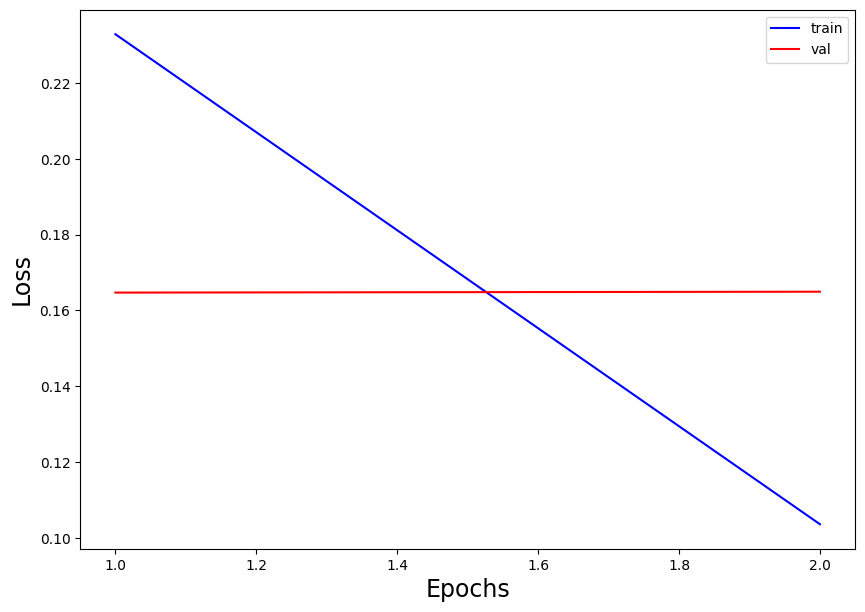

In [21]:
plt.figure(figsize = (10, 7))

plt.plot([i for i in range(1, num_epochs + 1)], hist.history['loss'], color = 'blue', label = 'train')
plt.plot([i for i in range(1, num_epochs + 1)], hist.history['val_loss'], color = 'red', label = 'val')

plt.xlabel('Epochs', fontsize = 17)
plt.ylabel('Loss', fontsize = 17)

plt.legend()
plt.show()

# 7. Save the model

In [22]:
model.save_weights(f'{path_general}/model/model')

### End of execution

In [23]:
end = time.time()

delta = (end - start)

hours = int(delta/3_600)
mins = int((delta - hours*3_600)/60)
secs = int(delta - hours*3_600 - mins*60)

print(f'Hours: {hours}, Minutes: {mins}, Seconds: {secs}')

Hours: 0, Minutes: 17, Seconds: 3
